# MSDS7333 Case Study 2
Julien Bataillard
Jared Law
Dennis Murray
Cory Nichols

In [2]:
import datetime as dt

import pandas as pd
from pandas import Series, DataFrame
from pandas_datareader import data as web
from pandas_datareader.yahoo.daily import YahooDailyReader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set date range
date_time_start = dt.datetime(2016, 1, 1)
date_time_end = dt.datetime(2017, 6, 1)

In [7]:
def get_portfolio():
    ''' Get portfolio of stocks using buggy Yahoo'''
    
    port = pd.DataFrame()
    names = ['DPZ', 'PZZA', 'YUM', 'FRSH', 'MCD', 'KHC', 'PLAY']
    for stock in names:
        while True:
            try:
                port[stock] = web.get_data_yahoo(stock, date_time_start, date_time_end)['Adj Close']
                break
            except:
                print('Unable to read stock: {0}, trying again'.format(stock))
    return port

sp = get_portfolio()

Unable to read stock: FRSH, trying again


In [9]:
sp.head()

,DPZ,PZZA,YUM,FRSH,MCD,KHC,PLAY
Date,,,,,,,
2016-01-04,107.016136,53.639576,49.635929,10.92,111.198700,68.692657,41.709999
2016-01-05,107.701935,53.414898,49.512199,10.77,112.730759,69.344627,41.889999
2016-01-06,107.545174,51.363480,49.161636,11.23,111.974197,69.476913,42.439999
2016-01-07,104.586395,49.546516,47.484421,10.71,109.382896,67.936745,41.209999
2016-01-08,106.761391,47.504875,46.838276,10.26,109.212654,67.256439,39.509998


In [146]:
sp.describe()

,DPZ,PZZA,YUM,FRSH,MCD,KHC,PLAY
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,150.082993,70.734861,60.114691,6.806108,119.322900,82.018186,47.492946
std,26.753015,12.272737,5.702535,2.493700,8.955579,6.643093,9.601552
min,102.048889,44.447296,45.143360,3.780000,106.960632,65.385567,31.080000
25%,128.926308,59.147450,56.932848,4.635000,112.730759,78.213539,39.432499
50%,148.920975,74.697812,61.987823,6.010000,117.520340,84.378331,45.414999
75%,169.158214,79.963510,63.475301,8.341250,122.467331,86.399870,56.204999
max,216.474655,88.525841,73.412682,12.810000,151.927551,93.931450,68.639999


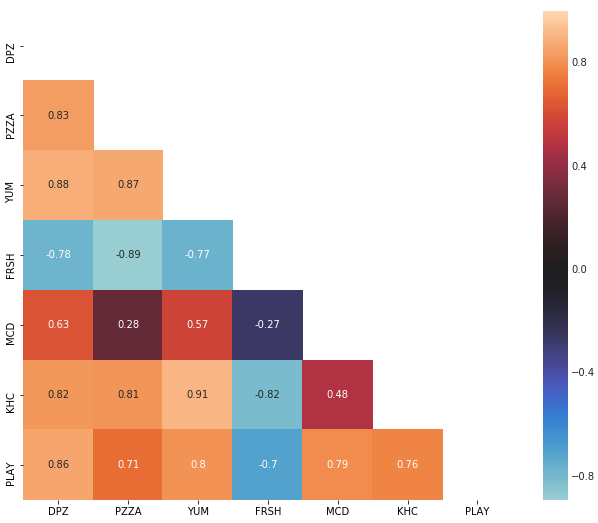

In [41]:
# check linear relationships
corr = sp.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, center=0, square=True, annot=True)

In [18]:
sp.corr()

,DPZ,PZZA,YUM,FRSH,MCD,KHC,PLAY
DPZ,1.000000,0.830060,0.884547,-0.782144,0.628713,0.816945,0.861754
PZZA,0.830060,1.000000,0.869706,-0.893370,0.280336,0.810672,0.705599
YUM,0.884547,0.869706,1.000000,-0.769067,0.573597,0.910452,0.801580
FRSH,-0.782144,-0.893370,-0.769067,1.000000,-0.270202,-0.817533,-0.704141
MCD,0.628713,0.280336,0.573597,-0.270202,1.000000,0.480926,0.786653
KHC,0.816945,0.810672,0.910452,-0.817533,0.480926,1.000000,0.764763
PLAY,0.861754,0.705599,0.801580,-0.704141,0.786653,0.764763,1.000000


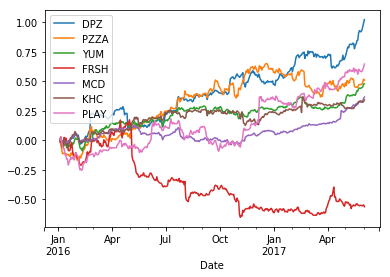

In [143]:
# transform to business day frequency and calculate percentage change in each daily shift
# show cumulative returns over time period of business days
sp = sp.asfreq('B').fillna(method='pad')
rets = sp.pct_change(1)
((1+rets).cumprod()-1).plot()
plt.show()

In [130]:
# potential reference: https://www.investopedia.com/terms/m/momentum_investing.asp
# compute momentum over a lookback and rank in descending order and standardize

def calc_meanRev(price, lookback, lag):
    '''Calculates pct change based on user input shift and lookback period'''
    meanRev = price.shift(lag).pct_change(lookback) 
    ranks = meanRev.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)


In [141]:
# SCRATCH
# meanRev discovery based on simple shifted period of 1 and pct_change lookback of 1
# ranks each stock on the business day's returns
# subtract the row mean from each stock's rank for the day
toy_df = sp[['PZZA','YUM']][:15]
print(toy_df.shift(1)[:10])

# change over two different points based on a 1 day lag and lookback
print(toy_df.shift(1).pct_change(3)[:10]) 

meanRev = toy_df.shift(1).pct_change(3)[:10]

# rank each stock based on their lookback returns for each day
ranks = meanRev.rank(axis=1, ascending=False)
demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
demeaned.divide(demeaned.std(axis=1), axis=0).dropna()


                 PZZA        YUM
Date                            
2016-01-04        NaN        NaN
2016-01-05  53.639576  49.635929
2016-01-06  53.414898  49.512199
2016-01-07  51.363480  49.161636
2016-01-08  49.546516  47.484421
2016-01-11  47.504875  46.838276
2016-01-12  47.563480  46.755791
2016-01-13  47.866306  47.821236
2016-01-14  47.641632  47.765884
2016-01-15  47.622089  48.444008
                PZZA       YUM
Date                          
2016-01-04       NaN       NaN
2016-01-05       NaN       NaN
2016-01-06       NaN       NaN
2016-01-07       NaN       NaN
2016-01-08 -0.076307 -0.043346
2016-01-11 -0.110644 -0.054005
2016-01-12 -0.073983 -0.048937
2016-01-13 -0.033912  0.007093
2016-01-14  0.002879  0.019804
2016-01-15  0.001232  0.036107


,PZZA,YUM
Date,,
2016-01-08,0.707107,-0.707107
2016-01-11,0.707107,-0.707107
2016-01-12,0.707107,-0.707107
2016-01-13,0.707107,-0.707107
2016-01-14,0.707107,-0.707107
2016-01-15,0.707107,-0.707107


In [102]:
compound = lambda x : (1+x).prod()-1
daily_sr = lambda x : x.mean() / x.std() # calculate mean portfolio return divided by std deviation
# Sharpe Ratio is avg return above risk free rate 
# Subtracting the risk-free rate from the mean return, 
# the performance associated with risk-taking activities can be isolated.
# > sharpe ratio = more attractive risk adjusted return
# (https://www.investopedia.com/terms/s/sharperatio.asp)

def strat_sr(prices, lb, hold):
    freq = '%dB' % hold
    # get ranked and standardized portfolio back
    port = calc_meanRev(prices, lb, lag = 1)
    
    daily_rets = prices.pct_change()
    
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)
    
    return daily_sr(port_rets) * np.sqrt(252/hold)

In [103]:
strat_sr(sp, 70, 30)

-0.6871485159555324

In [39]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(sp, lb, hold)
        
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [40]:
def heatmap(df, cmap = plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap = cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

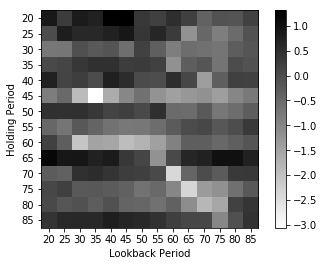

In [41]:
heatmap(ddf)
plt.show()